In [35]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import datetime
from graphviz import Digraph
import time
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import tabulate

In [2]:
sns.set(rc={'figure.figsize':(12.7,10.27)})

In [3]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
# Загрузка данных
df = pd.read_csv('/Users/kost/Desktop/решено/data/statistics-07-20.csv',sep=';',parse_dates=['operation_date'])
train_ops = pd.read_csv('/Users/kost/Desktop/решено/data/poezd.csv', sep=';', encoding='utf-8')
car_ops = pd.read_csv('/Users/kost/Desktop/решено/data/codes.csv',sep=';', encoding='utf-8')

In [5]:
# Датасет отсортированный по станции > номеру вагона > времени операции
ndf = df.sort_values(by=['operation_st_id','car_number','operation_date']).drop_duplicates().reset_index(drop=True)

# Инициализация переменных с номерами станции и вагона
st_id,car_num = 0,0 

### Переменные:

In [103]:
"""
Примеры номеров станций для анализа
"""
# st_id = 2000035744 # 100 ops, 4 cars
# st_id = 2002023503 # 90 ops, 28 cars
# st_id = 2000038836 # 50 ops, 10 cars
# st_id = 2000039118 # 54 ops, 9 cars
# st_id = 2002023867 # 515 ops, 74 cars
# st_id = 2000038976 # 207037 ops, 43702 cars
# st_id = 2001930816 # 82587 ops, 13178 cars
# st_id = 2000036868 # 37386 ops, 3801 cars
st_id = 2000036888 # 18489 ops, 363 cars
# st_id = 2000035392 #
# st_id = 2001930724

# проверка соответствия st_id и car_num
if ndf.operation_st_id[ndf.car_number == car_num][ndf.operation_st_id == st_id].shape[0] == 0:
    print(f'Для станции {st_id} нет записей с вагоном {car_num}')
    print(f'Топ 10 вагонов по количеству записей для станции:\n')
    print(
        pd.DataFrame(
            {'Вагон': ndf.car_number[ndf.operation_st_id == st_id].value_counts().index[:10],
             'Строк': ndf.car_number[ndf.operation_st_id == st_id].value_counts().values[:10]}
        )
    )  
else:
    print(
        f'Для станции {st_id} есть \
{ndf.operation_st_id[ndf.car_number == car_num][ndf.operation_st_id == st_id].shape[0]}\
 строк(а) по вагону {car_num}'
    )

Для станции 2000036888 есть 148 строк(а) по вагону 55864821


In [102]:
"""
Примеры номеров вагонов для анализа
"""
# car_num = 55864821 # вагон с максимальным количеством операций 310

# car_num = 94033792
# car_num = 62324355
# car_num = 37843901
# car_num = 61810677
# car_num = 37812401
# car_num = 37695855
# car_num = 30849038
# car_num = 63852057
# car_num = 42051045
# car_num = 44591014
car_num = 55864821

carSet = {car_num}

# проверка соответствия st_id и car_num
if ndf.operation_st_id[ndf.car_number == car_num][ndf.operation_st_id == st_id].shape[0] == 0:
    print(f'По вагону {car_num} нет записей на станции {st_id}')
    print(f'С этим вагоном есть записи на следующих станциях:\n')
    print(
        pd.DataFrame(
            {'Станция': ndf.operation_st_id[ndf.car_number == car_num].value_counts().index,
             'Строк': ndf.operation_st_id[ndf.car_number == car_num].value_counts().values}
        )
    )
else:
    print(
        f'Для станции {st_id} есть\
 {ndf.operation_st_id[ndf.car_number == car_num][ndf.operation_st_id == st_id].shape[0]} строк(а)\
 по вагону {car_num}'
    )

Для станции 2000036888 есть 148 строк(а) по вагону 55864821


In [86]:
"""
Примеры наборов номеров вагонов для анализа в модуле с отрисовкой графов. 
"""

# анализ по одному вагону
# carSet = {car_num}

# aнализ по набору вагонов

# анализ по станциям stations
# option A - Показать все цепочки операций по станции
# carSet = set(ndf.car_number[ndf.operation_st_id == st_id])

# option B - выбрать только цепочки длиннее заданного числа
st = ndf.car_number[ndf.operation_st_id == st_id].value_counts()
carSet = set(st[st > 2].index)

### Первичный анализ датасета

In [40]:
print(f'Размерность датасета: {ndf.shape}\n')
print(f'Временной диапазон:\nmin: {ndf.operation_date.min()}\nmax: {ndf.operation_date.max()}\n')

print(f'Уникальных станций: {ndf.operation_st_id.nunique()}')
print(f'Уникальных вагонов: {ndf.car_number.nunique()}\n')

print(f'Количество вагонов которые были отправлены хотя бы один раз:\
 {ndf.car_number[ndf.operation_car == 2].nunique()}')
print(f'В датасете нет данных об отправке\
 {ndf.car_number.nunique() - ndf.car_number[ndf.operation_car == 2].nunique()} уникальных вагонов\n')

print('Количество операций с вагонами без станции:')
ol = []
for op in list(ndf.operation_car[ndf.operation_st_id.isna()].value_counts().index):
    ol.append(car_ops[car_ops.index_code == op].values[0][1]) 

print(pd.DataFrame(
    {'Шифр': ol,
     'Опер.': ndf.operation_car[ndf.operation_st_id.isna()].value_counts().index,
     'Строк': ndf.operation_car[ndf.operation_st_id.isna()].value_counts().values
    }))

Размерность датасета: (4188138, 21)

Временной диапазон:
min: 2020-07-01 00:00:00
max: 2020-07-31 23:59:00

Уникальных станций: 744
Уникальных вагонов: 441248

Количество вагонов которые были отправлены хотя бы один раз: 312835
В датасете нет данных об отправке 128413 уникальных вагонов

Количество операций с вагонами без станции:
    Шифр  Опер.  Строк
0   ИСКП   3.00    123
1   ПВГУ  78.00     61
2   ПГР9  19.00     58
3   ВКЛП   4.00     55
4   ПВПП  80.00     52
5   ОТПР   2.00     49
6   ПГР4  13.00     43
7   ПГР0  18.00     37
8   ВЫГ1  20.00     36
9   УВГУ  79.00     35
10  ВЫГ2  21.00     25
11  УВПП  81.00     14
12  ПГР2  11.00     10


In [41]:
print('Уникальных операций с вагонами в датасете:')
for i in ndf.operation_car[ndf.operation_car.notnull()].value_counts().index:
    print(i,car_ops.description[car_ops.index_code == i].values)

Уникальных операций с вагонами в датасете:
4.0 ['ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              ']
80.0 [' ПОДАЧА ВАГОНА НА ПП                  ']
3.0 ['ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
2.0 ['ОТПРАВЛЕНИЕ ВАГОНА СО СТАНЦИИ         ']
81.0 ['УБОРКА ВАГОНА С ПП                    ']
18.0 ['ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ        ']
21.0 ['ВЫГРУЗКА НА ПП                        ']
10.0 ['ПОГРУЗКА НА МЕСТАХ ОБЩ.ПОЛЬЗОВАНИЯ    ']
11.0 ['ПОГРУЗКА НА ПП                        ']
19.0 ['ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ НА ПП  ']
20.0 ['ВЫГРУЗКА НА МЕСТАХ ОБЩ. ПОЛЬЗОВАНИЯ   ']
26.0 ['СДАЧА НА ИНОСТРАННУЮ Ж.Д.             ']
78.0 [' ПРОЧИЕ ПОДАЧИ ВАГОНА ГУ-45М          ']
79.0 [' ПРОЧИЕ УБОРКИ ВАГОНА ГУ-45М          ']
28.0 ['ВЫГРУЗКА БЕЗ ЗАЧЕТА В ВЫГРУЗКУ        ']
16.0 ['ПРИЕМ С ИНОСТРАННОЙ Ж.Д.              ']
27.0 ['ПЕРЕГРУЗ НА УЗКУЮ КОЛЕЮ               ']
13.0 ['ПРИЕМ С ВОДНОГО ТРАНСПОРТА            ']
29.0 ['ПРОЧИЕ, УЧИТЫВАЕМЫЕ КАК ВЫГРУЗКА      ']
14.0 ['ПРИЕМ С АВТОТРАНСПОРТА                ']


In [11]:
print('Уникальных операций с поездами в датасете:')
for i in ndf.operation_train[ndf.operation_train.notnull()].value_counts().index:
    print(i,train_ops.description[train_ops.index_code == i].values)

Уникальных операций с поездами в датасете:
5.0 ['Окончание формирования поезда']
4.0 ['Расформирование поезда']
2.0 ['Отпр. поезда со станции (без сдачи на дорогу,отделение,участок ДНЦ)']
72.0 ['Отцепка вагонов']
62.0 ['Отпр. поезда со станции со сдачей на соседний участок']
71.0 ['Прицепка вагонов']
22.0 ['Отпр. поезда co станции со сдачей на другую дорогу']
44.0 ['Подача маршрута под грузовые операции']
42.0 ['Отпр. поезда со станции со сдачей на соседнее отделение']
30.0 ['Отпр. (просл.) поезда со станции "чужой" дороги в направл. "нашей" дороги']
64.0 ['Приб. пассажирского поезда на станцию назначения']
54.0 ['Прекращение "жизни" поезда 3-й категории']
35.0 ['Образование соединенного поезда']


#### Справочные инструменты:

In [44]:
# по номеру операции вывести описание из справочников по вагонами и поездам
def get_op_info(operation_code):
    try:
        print(f'Операция с вагоном: {car_ops[car_ops.index_code == operation_code].values[0]}')
    except:
        print('NOP')
    try:
        print(f'Операция с поездом: {train_ops[train_ops.index_code == operation_code].values[0]}')
    except:
        print('NOP')
    
get_op_info(80)

Операция с вагоном: [80 'ПВПП' ' ПОДАЧА ВАГОНА НА ПП                  ']
NOP


In [47]:
# Выборка станций по количеству записей для станции в датасете:
df.operation_st_id.value_counts()[df.operation_st_id.value_counts() < 1000]

# df.operation_st_id.value_counts()

2,000,036,766.00    986
2,001,930,724.00    982
2,000,038,986.00    959
2,001,933,454.00    939
2,001,933,492.00    939
                   ... 
2,000,037,640.00      1
2,000,036,452.00      1
2,000,036,458.00      1
2,000,035,312.00      1
2,000,036,334.00      1
Name: operation_st_id, Length: 383, dtype: int64

In [14]:
# Выборка вагонов по количеству записей для вагона в датасете:
df.car_number.value_counts()[df.car_number.value_counts() == 50]
# df.car_number.value_counts()

30090294    50
52985215    50
53177598    50
58066317    50
61784906    50
            ..
63424105    50
30860639    50
56026339    50
30860712    50
61846879    50
Name: car_number, Length: 125, dtype: int64

### Избавление от пропусков

#### Операции с поездом когда нет данных по операции с вагоном:

In [15]:
for i in ndf.operation_train[ndf.operation_car.isna()].value_counts().index:
    print(i,train_ops.description[train_ops.index_code == i].values)

2.0 ['Отпр. поезда со станции (без сдачи на дорогу,отделение,участок ДНЦ)']
62.0 ['Отпр. поезда со станции со сдачей на соседний участок']
22.0 ['Отпр. поезда co станции со сдачей на другую дорогу']
42.0 ['Отпр. поезда со станции со сдачей на соседнее отделение']


In [16]:
# все пропуски можно заменить операцией отправления
ndf.operation_car = ndf.operation_car.fillna(2)

#### Предполагаем что если опасность вагона не указана, значит она отсутствует:

In [17]:
ndf.danger = ndf.danger.fillna(0)

### Визуализация датасета

In [91]:
print(f'st_id == {st_id}, в датасете с этой станцией имеются записи по:\n{ndf.car_number[ndf.operation_st_id == st_id].nunique()} вагонам и\n{ndf[ndf.operation_st_id == st_id].shape[0]} операциям')

st_id == 2002023867, в датасете с этой станцией имеются записи по:
74 вагонам и
515 операциям


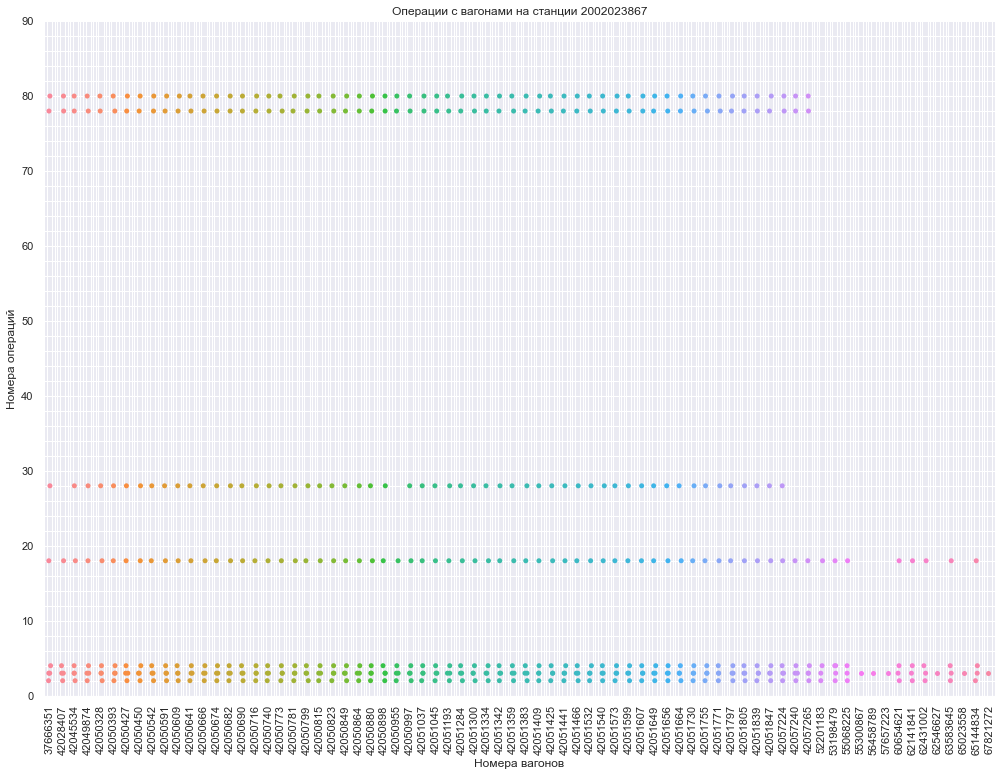

In [92]:
st_df = ndf[ndf.operation_st_id == st_id].sort_values(by=['operation_date']).reset_index(drop=True)
st_df = st_df[['car_number','operation_car']]

sns.catplot(x=st_df['car_number'], y=st_df['operation_car'], data=st_df,height=10, aspect=11.7/8.27)
plt.ylabel('Номера операций')
plt.xlabel('Номера вагонов')
plt.ylim(0, 90)
plt.xticks(rotation=90)
plt.minorticks_on()
plt.grid(which='minor')
plt.title(f'Операции с вагонами на станции {st_id}')
plt.show()

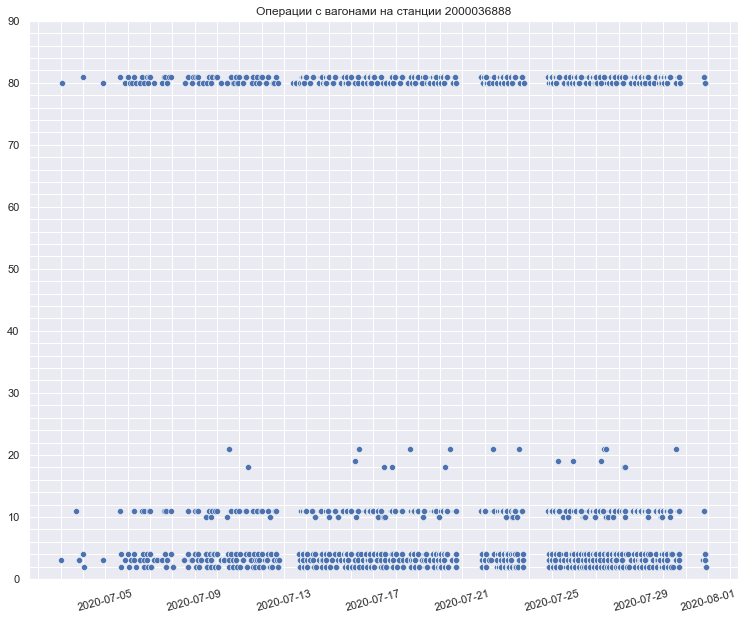

In [104]:
warnings.filterwarnings('ignore')

tmp_df = ndf[ndf.operation_st_id == st_id].sort_values(by='operation_date').reset_index(drop=True)
    
sns.scatterplot(x=tmp_df.operation_date.values,y=tmp_df.operation_car.values)
plt.xticks(rotation=15)
plt.title(f'Операции с вагонами на станции {st_id}')
plt.ylim(0, 90)
plt.minorticks_on()
plt.grid(which='minor')
plt.show()
del(tmp_df)

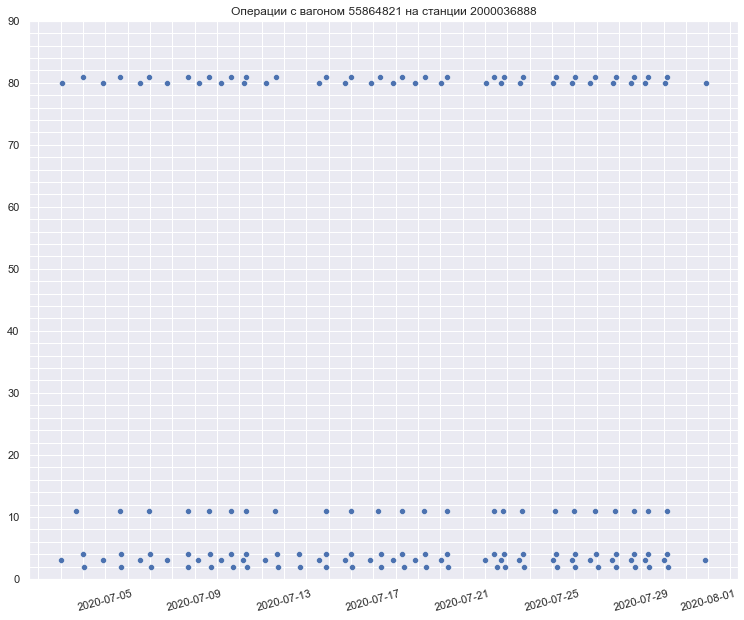

In [105]:
warnings.filterwarnings('ignore')
tmp_df = ndf[ndf.operation_st_id == st_id][ndf.car_number == car_num].sort_values(by='operation_date').reset_index(drop=True)
    
sns.scatterplot(x=tmp_df.operation_date.values,y=tmp_df.operation_car.values)
plt.xticks(rotation=15)
plt.title(f'Операции с вагоном {car_num} на станции {st_id}')
plt.ylim(0, 90)
plt.minorticks_on()
plt.grid(which='minor')
plt.show()
del(tmp_df)

#### Отрисовка графов последовательностей операций

In [59]:
def ops_tr_for_set_of_carts(cartsSet: set) -> pd.DataFrame:
    """
    Builds DF with historical data of changes in states from one operation to another for a set of carts IDs.
    :param cartsSet: set with carts numbers from nom_vag_op
    :return: dataframe with following format (note that state changes are not unique)
        from 	to
    0 	3 	    4
    1 	4 	    3
    2 	3 	    4
    3 	4 	    3
    ...
    """
    stateChangeDF = pd.DataFrame(columns=['from', 'to'])
    iter = 0
    for cartID in tqdm(cartsSet):
        iter += 1
        opsListCart = list(ndf[ndf.car_number == cartID].sort_values(by=['operation_date'])['operation_car'])
        state_change = pd.DataFrame({'from': opsListCart[:-1], 'to': opsListCart[1:]})
        stateChangeDF = pd.concat(
            [stateChangeDF, state_change],
            axis=0,
            join="outer",
            ignore_index=True,
            keys=None,
            levels=None,
            names=None,
            verify_integrity=False,
            copy=True,
        )
    return stateChangeDF


def count_ops_transitions(cartsSet: set) -> dict:
    """
    Builds a dict with unique operation changes and state change frequency.
    :param cartsSet: set with carts numbers from nom_vag_op
    :return: dict with unique operations and their quantity. See example below:
    {'3->4': 2, '4->3': 2, '3->2': 1, '2->80': 1}
    """
    sChangeList = []
    linksDict: dict = {}
    sChangeDF = ops_tr_for_set_of_carts(cartsSet)
    for i in range(sChangeDF.shape[0]):
        src = str(list(sChangeDF.loc[i])[0])
        trg = str(list(sChangeDF.loc[i])[1])
        sChangeList.append(src + "->" + trg)
    for entry in sChangeList:
        key = str(entry)
        if key in linksDict.keys():
            linksDict[key] += 1
        else:
            linksDict[key] = 1
    return linksDict

100%|██████████| 1/1 [00:00<00:00, 106.35it/s]


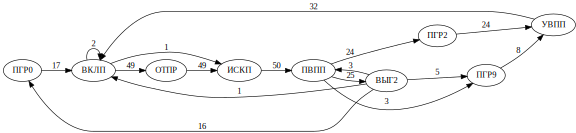

In [106]:
sdict = count_ops_transitions(carSet)

DG = Digraph('finite_state_machine', filename='ops_fsm')
DG.attr(rankdir='LR', size='8,5')

for key in sdict:
    src = car_ops[car_ops.index_code == float(key.split('->')[0])].values[0][1]
    dst = car_ops[car_ops.index_code == float(key.split('->')[1])].values[0][1]
    DG.edge(src, dst, weight=str(sdict[key]), label=str(sdict[key]))

DG

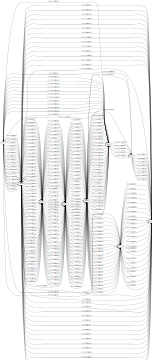

In [107]:
# построить граф переходов между операциями по вагону
# timedelta64[m] - 

cops = ndf[ndf.car_number == car_num].sort_values(by=['operation_date'])['operation_car'].index
DG = Digraph(f'FSM for car #{car_num}', filename='ops_fsm_per_car')
DG.attr(rankdir='LR', size='8,5')

for i in range(1,len(cops)):
    src = car_ops.mnem_code[car_ops.index_code == ndf.operation_car[ndf.index == cops[i-1]].values[0]].values[0]
    dst = car_ops.mnem_code[car_ops.index_code == ndf.operation_car[ndf.index == cops[i]].values[0]].values[0]
    td = ndf.operation_date[ndf.index == cops[i]].values[0] - ndf.operation_date[ndf.index == cops[i-1]].values[0]
    td = str(td.astype('timedelta64[m]'))
    DG.edge(src, dst, label=f'#{str(i)} - {td}')


# DG.view() # выгрузить в pdf
DG # отобразить граф в ячейке

In [25]:
ndf.columns

Index(['index_train', 'length', 'car_number', 'destination_esr', 'adm',
       'danger', 'gruz', 'loaded', 'operation_car', 'operation_date',
       'operation_st_esr', 'operation_st_id', 'operation_train', 'receiver',
       'rodvag', 'rod_train', 'sender', 'ssp_station_esr', 'ssp_station_id',
       'tare_weight', 'weight_brutto'],
      dtype='object')

In [63]:
ndf[ndf.car_number == car_num].sort_values(by=['operation_date'])[['operation_car','operation_st_esr','destination_esr','ssp_station_esr','index_train']].reset_index(drop=True)

,operation_car,operation_st_esr,destination_esr,ssp_station_esr,index_train
0,18.00,"852,106.00","852,303.00",NaN,NaN
1,4.00,"852,106.00","852,303.00","850,007.00","852,106,669,850,007.00"
2,4.00,"852,106.00","852,303.00","850,007.00","852,106,670,850,007.00"
3,2.00,"852,106.00","852,303.00","852,303.00","852,106,670,852,303.00"
4,3.00,"852,303.00","852,303.00","852,303.00","852,106,670,852,303.00"
5,18.00,"852,303.00","852,106.00",NaN,NaN
6,4.00,"852,303.00","852,106.00","852,200.00","852,303,682,852,200.00"
7,2.00,"852,303.00","852,106.00","852,106.00","852,303,682,852,106.00"
8,3.00,"852,106.00","852,106.00","852,106.00","852,303,682,852,106.00"
9,80.00,"852,106.00","852,106.00",NaN,NaN


### Анализ цепочек операций

#### Выборка по станции. Словарь с последовательностями операций по вагонам

In [64]:
def extract_ops_chains(st_id: int) -> dict:
    '''
    Собирает цепочки операций по вагонам для заданной станции
    '''
    cars = {}
    for i in tqdm(ndf.car_number[ndf.operation_st_id == st_id].unique()):
        cars[i] = str(ndf.operation_car[ndf.operation_st_id == st_id][ndf.car_number == i].values)
        cars[i] = cars[i][1:-1].strip().replace('\n','')
    return cars

def sort_dict(dct: dict) -> dict:
    '''
    Сортирует цепочки операций
    '''
    return dict(sorted(dct.items(), key=lambda item: item[1], reverse=True))

In [108]:
cars_ops = sort_dict(extract_ops_chains(st_id))
cars_ops

100%|██████████| 363/363 [00:04<00:00, 87.66it/s]


{55822928: '81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80.',
 55952584: '80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  4.  2.',
 55999445: '80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 

### Аггрегация вагонов по типовым последовательностям операций

In [67]:
def agg_by_car(dct: dict) -> dict:
    '''
    Аггрегирует номера вагонов по цепочкам операций
    '''
    res = {}
    for i, v in dct.items():
        res[v] = [i] if v not in res.keys() else res[v] + [i]
    return res

In [109]:
agg_by_car(cars_ops)

{'81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80.': [55822928],
 '80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  4.  2.': [55952584],
 '80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11

In [110]:
# подсчет цепочек операций совпадающих по вагонам
ocl = agg_by_car(cars_ops)
for key in ocl:
    ocl[key] = len(ocl[key])
ocl = sort_dict(ocl)
ocl

{'3. 80. 11. 81.  4.  2.  3. 80.': 15,
 '3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.': 14,
 '3. 80. 10.  4.  2.': 14,
 '3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.': 11,
 '3. 80. 10.  4.  2.  3. 80.': 11,
 '3. 80.': 10,
 '3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.': 9,
 '3. 80. 10.  4.  4.  2.  3. 80. 10.  4.  2.': 8,
 '3. 80. 10.  4.  2.  3. 80. 10.  4.  2.': 8,
 '3. 80. 10.  4.  2. 10.  4.  2.': 7,
 '4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  

In [118]:
# цепочка операций для вагона car_num
# ops = list(ndf.operation_car[ndf.car_number == car_num].values)



ops = list(ocl.keys())[0]
ops = list(map(float, ops.split()))
print(f'Самая повторяющаяся цепочка операций на станции {st_id}:\n{ops}')

Самая повторяющаяся цепочка операций на станции 2000036888:
[3.0, 80.0, 11.0, 81.0, 4.0, 2.0, 3.0, 80.0]


In [119]:
# описание цепочки операций ops
for i in ops:
    print(car_ops[car_ops.index_code == i].values[0])

[3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
[80 'ПВПП' ' ПОДАЧА ВАГОНА НА ПП                  ']
[11 'ПГР2' 'ПОГРУЗКА НА ПП                        ']
[81 'УВПП' 'УБОРКА ВАГОНА С ПП                    ']
[4 'ВКЛП' 'ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              ']
[2 'ОТПР' 'ОТПРАВЛЕНИЕ ВАГОНА СО СТАНЦИИ         ']
[3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
[80 'ПВПП' ' ПОДАЧА ВАГОНА НА ПП                  ']


## Черновик:

### Профайлер

In [34]:
## profiler code
# dt = datetime.datetime.now().strftime("%m/%d/%y - %H:%M")
# profile = ProfileReport(ndf, title=dt, explorative=True)
# fname = 'pd-report.html'
# profile.to_file(output_file=fname)